# Predicción de Precios de Vehículos Usados (Core)

implementar y evaluar modelos de regresión, y seleccionar el mejor modelo basado en las métricas de evaluación.

### Requisitos:

 1. Carga y Exploración de Datos:

* Descargar y cargar el dataset.
* Realizar una exploración inicial para entender la estructura del dataset.
* Identificar valores faltantes, duplicados y outliers.
 2. Limpieza y Preprocesamiento:

* Manejar valores faltantes.
* Eliminar duplicados.
* Corregir inconsistencias en los datos categóricos.
* Escalar las características numéricas.
* Realizar transformaciones necesarias para las características categóricas.
 3. Exploración de Datos:

* Crear visualizaciones univariadas y multivariadas.
* Calcular estadísticas descriptivas.
 4. Modelado y Evaluación:

* Implementar al menos dos modelos de regresión (Linear Regression y Random Forest Regressor).
* Evaluar los modelos utilizando MSE, RMSE, y R^2.
* Seleccionar el mejor modelo basado en las métricas de evaluación.
 5. Optimización del Modelo:

* Optimizar el modelo seleccionado utilizando GridSearchCV.
 6. Documentación y Entrega:

* Documentar todo el proceso en un archivo .ipynb claramente comentado.
* Crear visualizaciones con interpretaciones.
* Subir el archivo a un repositorio en GitHub con un tag de liberación.



### **EDA**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import utils

In [ ]:
#data = pd.read_csv('/Users/guill/Documents/vehicles.csv')

Eliminamos las columnas innecesarias

In [3]:
data.drop(columns=['id', 'url', 'region', 'region_url','image_url','description','lat', 'long', 'posting_date','VIN', 'county'], inplace=True)

Convertimos la columna cylinders por numerica

In [4]:
data.cylinders.unique()

array([nan, '8 cylinders', '6 cylinders', '4 cylinders', '5 cylinders',
       'other', '3 cylinders', '10 cylinders', '12 cylinders'],
      dtype=object)

In [5]:
# Diccionario para mapear texto a números
cylinder_mapping = {
    '8 cylinders': 8,
    '6 cylinders': 6,
    '4 cylinders': 4,
    '5 cylinders': 5,
    '3 cylinders': 3,
    '10 cylinders': 10,
    '12 cylinders': 12,
    'other': None  # Puedes decidir si 'other' será NaN o un valor específico
}

# Reemplazar los valores en la columna 'cylinders'
data['cylinders'] = data['cylinders'].map(cylinder_mapping)
data.cylinders.unique()


array([nan,  8.,  6.,  4.,  5.,  3., 10., 12.])

Damos consistencia a sus Dtypes correspondientes

In [6]:
data_dict = {
    #'region': 'category',
    'price': 'float',
    'year': 'float',
    'manufacturer': 'category',
    'model': 'string',
    'condition': 'category',
    'cylinders': 'float',
    'fuel': 'category',
    'odometer': 'float',
    'title_status': 'category',
    'transmission': 'category',
    'drive': 'category',
    'size': 'category',
    'type': 'category',
    'paint_color': 'category',
    'state': 'category'
}
# Convertir tipos de datos según el diccionario
for column, dtype in data_dict.items():
    data[column] = data[column].astype(dtype, errors='ignore')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   price         426880 non-null  float64 
 1   year          425675 non-null  float64 
 2   manufacturer  409234 non-null  category
 3   model         421603 non-null  string  
 4   condition     252776 non-null  category
 5   cylinders     247904 non-null  float64 
 6   fuel          423867 non-null  category
 7   odometer      422480 non-null  float64 
 8   title_status  418638 non-null  category
 9   transmission  424324 non-null  category
 10  drive         296313 non-null  category
 11  size          120519 non-null  category
 12  type          334022 non-null  category
 13  paint_color   296677 non-null  category
 14  state         426880 non-null  category
dtypes: category(10), float64(4), string(1)
memory usage: 20.4 MB


array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 'cylinders'}>,
        <Axes: title={'center': 'odometer'}>]], dtype=object)

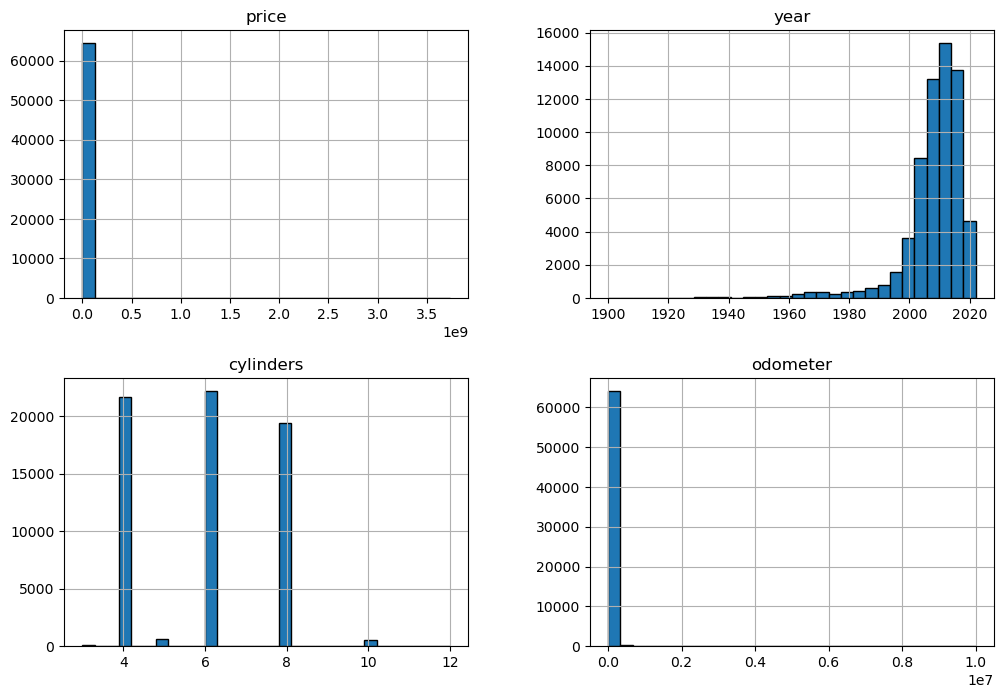

In [57]:
data.dropna().hist(figsize=(12, 8), bins=30, edgecolor='black')

Eliminamos duplicados

In [7]:
# Identificar duplicados
duplicados = data.duplicated()
# Contar el número de duplicados
num_duplicados = duplicados.sum()
print(f"Número de registros duplicados antes de eliminarlos: {num_duplicados}")

# Eliminar duplicados y actualizar el DataFrame
data = data.drop_duplicates()

# Identificar duplicados nuevamente
duplicados = data.duplicated()
# Contar el número de duplicados
num_duplicados = duplicados.sum()
print(f"Número de registros duplicados después de eliminarlos: {num_duplicados}")


Número de registros duplicados antes de eliminarlos: 127691
Número de registros duplicados después de eliminarlos: 0


Dividimos los datos en Categoricos y Numericos para poder trabajar mejor

In [8]:
numeric_cols = data.select_dtypes(include=['float', 'int'])
categorical_cols = data.select_dtypes(include=['category', 'bool'])

Consistencia en valores categoricos

In [9]:
# Aplicar la limpieza a las columnas categóricas
for col in categorical_cols:
    categorical_cols[col] = categorical_cols[col].apply(utils.limpiar_cadena)
# Verificar los cambios
for col in categorical_cols:
    print(f"\nValores únicos después de limpieza en '{col}':")
    print(categorical_cols[col].unique())


Valores únicos después de limpieza en 'manufacturer':
[NaN, 'gmc', 'chevrolet', 'toyota', 'ford', ..., 'harley-davidson', 'datsun', 'aston-martin', 'land rover', 'morgan']
Length: 43
Categories (42, object): ['acura', 'alfa-romeo', 'aston-martin', 'audi', ..., 'tesla', 'toyota', 'volkswagen', 'volvo']

Valores únicos después de limpieza en 'condition':
[NaN, 'good', 'excellent', 'fair', 'like new', 'new', 'salvage']
Categories (6, object): ['excellent', 'fair', 'good', 'like new', 'new', 'salvage']

Valores únicos después de limpieza en 'fuel':
[NaN, 'gas', 'other', 'diesel', 'hybrid', 'electric']
Categories (5, object): ['diesel', 'electric', 'gas', 'hybrid', 'other']

Valores únicos después de limpieza en 'title_status':
[NaN, 'clean', 'rebuilt', 'lien', 'salvage', 'missing', 'parts only']
Categories (6, object): ['clean', 'lien', 'missing', 'parts only', 'rebuilt', 'salvage']

Valores únicos después de limpieza en 'transmission':
[NaN, 'other', 'automatic', 'manual']
Categories (3,

Mapeamos las columnas categoricas para ver los valores unicos

In [10]:
# Identificar columnas de tipo 'object', típicamente usadas para variables categóricas
categorical_columns = data.select_dtypes(include=['category','bool']).columns
# Crear un diccionario donde cada clave es el nombre de la columna y los valores son los valores únicos de esa columna
unique_values_dict = {col: data[col].unique() for col in categorical_columns}
# Convertir el diccionario en un DataFrame, rellenando con NaN cuando haya menos valores únicos
unique_values_df = pd.DataFrame.from_dict(unique_values_dict, orient='index').transpose()
# Mostrar el DataFrame resultante
unique_values_df.T

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
manufacturer,NaN,gmc,chevrolet,toyota,ford,jeep,nissan,ram,mazda,cadillac,...,land rover,morgan,None,None,None,None,None,None,None,None
condition,NaN,good,excellent,fair,like new,new,salvage,None,None,None,...,None,None,None,None,None,None,None,None,None,None
fuel,NaN,gas,other,diesel,hybrid,electric,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
title_status,NaN,clean,rebuilt,lien,salvage,missing,parts only,None,None,None,...,None,None,None,None,None,None,None,None,None,None
transmission,NaN,other,automatic,manual,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
drive,NaN,rwd,4wd,fwd,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
size,NaN,full-size,mid-size,compact,sub-compact,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
type,NaN,pickup,truck,other,coupe,SUV,hatchback,mini-van,sedan,offroad,...,None,None,None,None,None,None,None,None,None,None
paint_color,NaN,white,blue,red,black,silver,grey,brown,yellow,orange,...,None,None,None,None,None,None,None,None,None,None
state,az,ar,fl,ma,nc,ny,or,pa,tx,wa,...,ok,ri,sc,sd,tn,ut,vt,va,wv,wy


Verificamos si existen Booleanos

In [11]:
# Detectar columnas con valores únicos ['Yes', 'No']
yes_no_columns = [col for col in data.columns if sorted(data[col].dropna().unique()) == ['No', 'Yes']]
print("Columnas con valores 'Yes' y 'No':", yes_no_columns)
# Aplicar el mapeo 'Yes' -> 1 y 'No' -> 0 a todas las columnas de una vez usando map y itertools
data[yes_no_columns] = pd.DataFrame(
    map(lambda col: data[col].map({'Yes': 1, 'No': 0}), yes_no_columns)
).T.set_axis(yes_no_columns, axis=1)

Columnas con valores 'Yes' y 'No': []


Consistencia en Valores Numericos

In [12]:
# Crear un diccionario para almacenar las estadísticas
estadisticas_dict = {}
# Iterar sobre cada columna numérica y calcular las estadísticas
for columna in numeric_cols:
    datos_columna = data[columna].values
    estadisticas = utils.calcular_estadisticas(columna, datos_columna)
    estadisticas_dict[columna] = estadisticas
# Convertir el diccionario a un DataFrame para una mejor visualización
estadisticas_df = pd.DataFrame(estadisticas_dict).T  # Transponer para que las columnas sean las filas
estadisticas_df = estadisticas_df[['Cuenta', 'Media', 'Mediana', 'Desviación Estándar', 
                                   'Mínimo', 'Máximo', '25% Percentil', '75% Percentil']]
# Redondear las estadísticas a 2 decimales
estadisticas_df = estadisticas_df.round(2)
# Mostrar el DataFrame formateado
print("\nEstadísticas Descriptivas (Redondeadas a 2 decimales):")
estadisticas_df


Estadísticas Descriptivas (Redondeadas a 2 decimales):


,Cuenta,Media,Mediana,Desviación Estándar,Mínimo,Máximo,25% Percentil,75% Percentil
price,299189.0,98671.46,12500.0,14551384.10,0.0,3.736929e+09,5500.0,24500.0
year,298320.0,2010.28,2013.0,10.42,1900.0,2.022000e+03,2007.0,2017.0
cylinders,181966.0,5.93,6.0,1.61,3.0,1.200000e+01,4.0,8.0
odometer,296493.0,103574.94,90565.0,232879.73,0.0,1.000000e+07,40842.0,138917.0


In [13]:
utils.calculate_na_statistics(numeric_cols)

,datos sin NAs en q,Na en q,Na en %
cylinders,181966,117223,39.18
odometer,296493,2696,0.90
year,298320,869,0.29
price,299189,0,0.00


In [14]:

# Create a summary DataFrame for outliers
outliers_summary = pd.DataFrame()
for column in numeric_cols:
    outliers = utils.detect_outliers_iqr(numeric_cols[column])
    outliers_summary[column] = {
        'Number of Outliers': outliers.sum(),
        'Percentage of Outliers': 100 * outliers.mean(),
        'Lower Bound': numeric_cols[column][~outliers].min(),
        'Upper Bound': numeric_cols[column][~outliers].max()
    }

# Save the summary to a CSV file
outliers_summary.T

,Number of Outliers,Percentage of Outliers,Lower Bound,Upper Bound
price,7344.0,2.454636,0.0,53000.0
year,12706.0,4.246814,1992.0,2022.0
cylinders,0.0,0.000000,3.0,12.0
odometer,3366.0,1.125041,0.0,286011.0


In [15]:
# Calcular la matriz de correlación utilizando Pearson
matriz_correlacion = numeric_cols.dropna().corr(method='pearson')
# Mostrar la matriz de correlación
print("\nMatriz de Correlación (Pearson):")
matriz_correlacion


Matriz de Correlación (Pearson):


,price,year,cylinders,odometer
price,1.000000,-0.000712,0.004479,0.000613
year,-0.000712,1.000000,-0.185140,-0.127676
cylinders,0.004479,-0.185140,1.000000,0.029980
odometer,0.000613,-0.127676,0.029980,1.000000


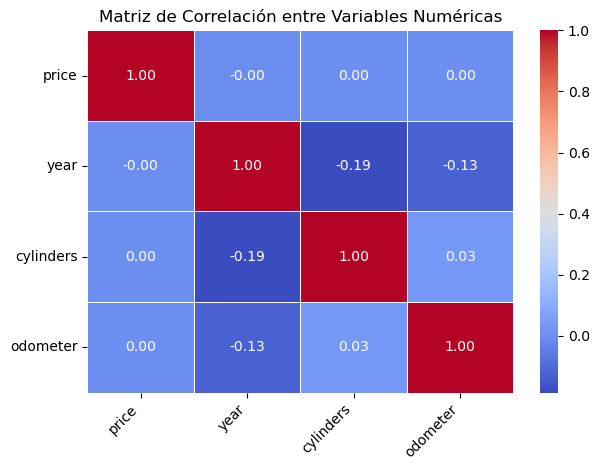

In [16]:
# Configurar el tamaño de la figura
plt.figure()
# Crear el heatmap utilizando seaborn
sns.heatmap(matriz_correlacion, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
# Añadir títulos y etiquetas
plt.title('Matriz de Correlación entre Variables Numéricas')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
# Mostrar el gráfico
plt.tight_layout()
plt.show()

Preprocesamos los datos para poder mejorar los modelos, esto incluyen, imputar por mean, luego eliminar outliers y seleccionar una muestra pequeña del 5% del total

In [33]:
numeric_cols = numeric_cols.fillna(numeric_cols.mean())


In [43]:
numeric_cols

,price,year,cylinders,odometer
0,6000.0,2010.282147,5.925816,103574.939779
1,11900.0,2010.282147,5.925816,103574.939779
2,21000.0,2010.282147,5.925816,103574.939779
3,1500.0,2010.282147,5.925816,103574.939779
4,4900.0,2010.282147,5.925816,103574.939779
...,...,...,...,...
426875,23590.0,2019.000000,6.000000,32226.000000
426876,30590.0,2020.000000,5.925816,12029.000000
426877,34990.0,2020.000000,5.925816,4174.000000
426878,28990.0,2018.000000,6.000000,30112.000000


In [20]:
# Asegurarse de que las columnas categóricas sean de tipo 'category'
categorical_cols = categorical_cols.apply(lambda x: x.astype('category') if x.dtype != 'category' else x)

# Añadir la categoría 'unknown' y rellenar los NaN
categorical_cols = categorical_cols.apply(lambda x: x.cat.add_categories('unknown').fillna('unknown') if x.dtype.name == 'category' else x)


In [21]:
categorical_cols

,manufacturer,condition,fuel,title_status,transmission,drive,size,type,paint_color,state
0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,az
1,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,ar
2,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,fl
3,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,ma
4,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,nc
...,...,...,...,...,...,...,...,...,...,...
426875,nissan,good,gas,clean,other,fwd,unknown,sedan,unknown,wy
426876,volvo,good,gas,clean,other,fwd,unknown,sedan,red,wy
426877,cadillac,good,diesel,clean,other,unknown,unknown,hatchback,white,wy
426878,lexus,good,gas,clean,other,fwd,unknown,sedan,silver,wy


### **Modelos**

In [22]:
data2 = pd.concat([numeric_cols, categorical_cols], axis=1)
data2


,price,year,cylinders,odometer,manufacturer,condition,fuel,title_status,transmission,drive,size,type,paint_color,state
0,6000.0,2010.282147,5.925816,103574.939779,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,az
1,11900.0,2010.282147,5.925816,103574.939779,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,ar
2,21000.0,2010.282147,5.925816,103574.939779,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,fl
3,1500.0,2010.282147,5.925816,103574.939779,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,ma
4,4900.0,2010.282147,5.925816,103574.939779,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,nc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590.0,2019.000000,6.000000,32226.000000,nissan,good,gas,clean,other,fwd,unknown,sedan,unknown,wy
426876,30590.0,2020.000000,5.925816,12029.000000,volvo,good,gas,clean,other,fwd,unknown,sedan,red,wy
426877,34990.0,2020.000000,5.925816,4174.000000,cadillac,good,diesel,clean,other,unknown,unknown,hatchback,white,wy
426878,28990.0,2018.000000,6.000000,30112.000000,lexus,good,gas,clean,other,fwd,unknown,sedan,silver,wy


Eliminamos duplicados

In [23]:
data2.duplicated().sum()


2552

In [24]:
data2.drop_duplicates(inplace=True)

In [25]:
data2_numeric = data2.select_dtypes(include=['float', 'int'])
data2_categorical = data2.select_dtypes(include=['category', 'bool'])

In [26]:
data2

,price,year,cylinders,odometer,manufacturer,condition,fuel,title_status,transmission,drive,size,type,paint_color,state
0,6000.0,2010.282147,5.925816,103574.939779,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,az
1,11900.0,2010.282147,5.925816,103574.939779,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,ar
2,21000.0,2010.282147,5.925816,103574.939779,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,fl
3,1500.0,2010.282147,5.925816,103574.939779,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,ma
4,4900.0,2010.282147,5.925816,103574.939779,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,nc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590.0,2019.000000,6.000000,32226.000000,nissan,good,gas,clean,other,fwd,unknown,sedan,unknown,wy
426876,30590.0,2020.000000,5.925816,12029.000000,volvo,good,gas,clean,other,fwd,unknown,sedan,red,wy
426877,34990.0,2020.000000,5.925816,4174.000000,cadillac,good,diesel,clean,other,unknown,unknown,hatchback,white,wy
426878,28990.0,2018.000000,6.000000,30112.000000,lexus,good,gas,clean,other,fwd,unknown,sedan,silver,wy


Dado que el algoritmo de RF usa muchos recursos, decido tomar una pequeña muestra del Dataset limpio para ejecutar el analisis.

In [27]:
sample_size = 0.05  # Porcentaje de muestra, 5% en este caso
data_sample = data2.sample(frac=sample_size, random_state=42)  # Puedes ajustar 'random_state' para reproducibilidad

# Verificar las primeras filas de la muestra
data_sample

,price,year,cylinders,odometer,manufacturer,condition,fuel,title_status,transmission,drive,size,type,paint_color,state
224433,59999.0,2020.0,5.925816,7155.0,ford,unknown,diesel,clean,automatic,wd,unknown,other,white,mt
204110,0.0,2013.0,5.925816,150000.0,dodge,unknown,gas,clean,automatic,unknown,unknown,unknown,unknown,mi
95360,15498.0,2013.0,6.000000,66624.0,ford,like new,gas,clean,automatic,fwd,mid-size,suv,brown,fl
165586,3997.0,1998.0,5.925816,195666.0,ford,unknown,gas,clean,automatic,fwd,unknown,pickup,blue,ks
251353,9995.0,2016.0,5.925816,34278.0,kia,unknown,gas,clean,manual,unknown,unknown,unknown,unknown,nj
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108382,27980.0,2016.0,5.925816,61092.0,mercedes-benz,excellent,gas,clean,automatic,rwd,unknown,suv,black,fl
21768,55000.0,2020.0,8.000000,13000.0,ford,new,gas,clean,automatic,unknown,unknown,unknown,white,ca
30012,16900.0,2014.0,4.000000,63840.0,bmw,excellent,gas,clean,automatic,rwd,unknown,sedan,blue,ca
397137,0.0,2015.0,5.925816,63776.0,ram,unknown,gas,clean,automatic,unknown,unknown,other,silver,va


In [44]:
#Eliminar los outliers de las columnas numericas
data_sample = data_sample[(np.abs(stats.zscore(data_sample.select_dtypes(include=['float64', 'int']).values)) < 3).all(axis=1)]
data_sample

,price,year,cylinders,odometer,manufacturer,condition,fuel,title_status,transmission,drive,size,type,paint_color,state
224433,59999.0,2020.0,5.925816,7155.0,ford,unknown,diesel,clean,automatic,wd,unknown,other,white,mt
204110,0.0,2013.0,5.925816,150000.0,dodge,unknown,gas,clean,automatic,unknown,unknown,unknown,unknown,mi
95360,15498.0,2013.0,6.000000,66624.0,ford,like new,gas,clean,automatic,fwd,mid-size,suv,brown,fl
165586,3997.0,1998.0,5.925816,195666.0,ford,unknown,gas,clean,automatic,fwd,unknown,pickup,blue,ks
251353,9995.0,2016.0,5.925816,34278.0,kia,unknown,gas,clean,manual,unknown,unknown,unknown,unknown,nj
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108382,27980.0,2016.0,5.925816,61092.0,mercedes-benz,excellent,gas,clean,automatic,rwd,unknown,suv,black,fl
21768,55000.0,2020.0,8.000000,13000.0,ford,new,gas,clean,automatic,unknown,unknown,unknown,white,ca
30012,16900.0,2014.0,4.000000,63840.0,bmw,excellent,gas,clean,automatic,rwd,unknown,sedan,blue,ca
397137,0.0,2015.0,5.925816,63776.0,ram,unknown,gas,clean,automatic,unknown,unknown,other,silver,va


#### **Lineal Regression**

In [48]:
# Separar características y etiquetas
X = data_sample.drop(columns=['price'])
y = data_sample['price']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.28, random_state=0, shuffle=True
)

# Definir transformaciones
numeric_features = X.select_dtypes(include=['float64', 'int']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

categorical_features = X.select_dtypes(include=['category', 'bool']).columns
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar transformaciones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Crear pipeline completo incluyendo el modelo
pipeline_completo = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Entrenar el pipeline completo
pipeline_completo.fit(X_train, y_train)

# Realizar predicciones
y_pred = pipeline_completo.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Error Cuadrático Medio: {mse}')
print(f'R-cuadrado: {r2}')

Error Cuadrático Medio: 88472210.11979395
R-cuadrado: 0.5153717335811145


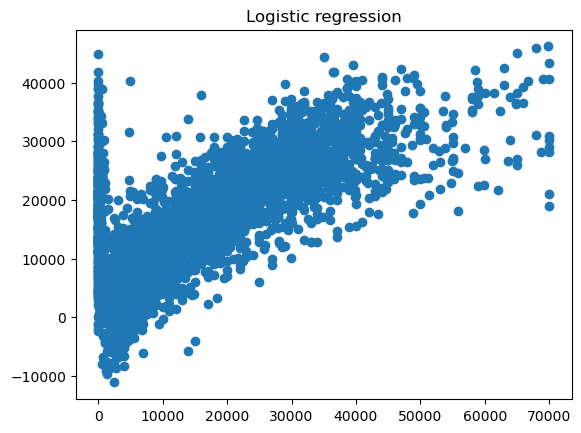

In [50]:
plt.title('Logistic regression')
plt.scatter(y_test, y_pred)

#### **Random Forest**

In [52]:
# Dividir el conjunto de datos en variables predictoras (X) y la variable objetivo (y)
X = data_sample.drop(columns=['price'])
y = data_sample['price']

# Dividir el conjunto de datos en entrenamiento y prueba (28% de prueba)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.28, random_state=0, shuffle=True
)

# Definir transformaciones para características numéricas
numeric_features = X.select_dtypes(include=['float64', 'int']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Rellenar valores nulos con 0
    ('scaler', StandardScaler())  # Normalizar los datos numéricos
])

# Definir transformaciones para características categóricas
categorical_features = X.select_dtypes(include=['category', 'object']).columns
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Convertir variables categóricas a variables dummy
])

# Combinar transformaciones para columnas numéricas y categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Crear pipeline completo incluyendo el preprocesamiento y el modelo de regresión
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=0))  # Modelo RandomForestRegressor
])

# Entrenar el modelo
pipeline_rf.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = pipeline_rf.predict(X_test)

# Evaluar el rendimiento del modelo utilizando el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Puedes también evaluar otras métricas como el R²
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')

Mean Squared Error: 72726509.87148674
R² Score: 0.6016226750299175


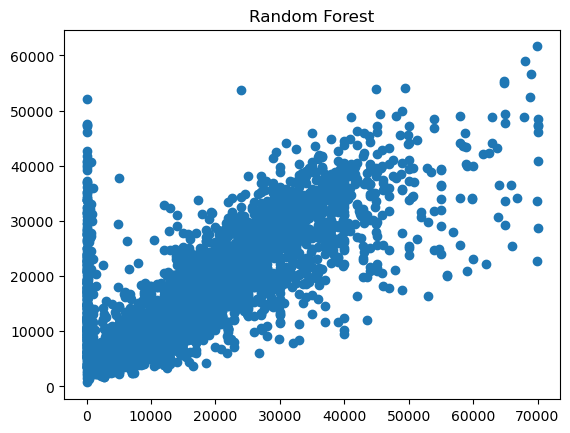

In [53]:
plt.title('Random Forest')
plt.scatter(y_test, y_pred)